# ETL Pipeline and Star Schema Design

In [39]:
import pandas as pd
import numpy as np
import json
import glob
from google.oauth2.service_account import Credentials # for BigQuery authentication

## 1. Extract

In [22]:
def import_and_extract_json_data(path_to_json_files):
    """
    Imports and extracts data from JSON files into a list of dictionaries.

    Parameters:
    path_to_json_files (str): Path to the directory containing JSON files.

    Returns:
    list: A list of dictionaries containing the data from the JSON files.
    """
    files = glob.glob(f"{path_to_json_files}/*.json")
    data = []
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                log_entry = json.loads(line)
                data.append(log_entry)
    return data

# call function to extract songs data
path_to_songs_files = "/Path/To/JSON/song_data"
songs = import_and_extract_json_data(path_to_songs_files)
# call function to extract logs data
path_to_logs_files = "/Path/To/JSON/log_data"
logs = import_and_extract_json_data(path_to_logs_files)
songs[0:5]

[{'num_songs': 1,
  'artist_id': 'ARD7TVE1187B99BFB1',
  'artist_latitude': None,
  'artist_longitude': None,
  'artist_location': 'California - LA',
  'artist_name': 'Casual',
  'song_id': 'SOMZWCG12A8C13C480',
  'title': "I Didn't Mean To",
  'duration': 218.93179,
  'year': 0},
 {'num_songs': 1,
  'artist_id': 'ARMJAGH1187FB546F3',
  'artist_latitude': 35.14968,
  'artist_longitude': -90.04892,
  'artist_location': 'Memphis, TN',
  'artist_name': 'The Box Tops',
  'song_id': 'SOCIWDW12A8C13D406',
  'title': 'Soul Deep',
  'duration': 148.03546,
  'year': 1969},
 {'num_songs': 1,
  'artist_id': 'ARKRRTF1187B9984DA',
  'artist_latitude': None,
  'artist_longitude': None,
  'artist_location': '',
  'artist_name': 'Sonora Santanera',
  'song_id': 'SOXVLOJ12AB0189215',
  'title': 'Amor De Cabaret',
  'duration': 177.47546,
  'year': 0},
 {'num_songs': 1,
  'artist_id': 'AR7G5I41187FB4CE6C',
  'artist_latitude': None,
  'artist_longitude': None,
  'artist_location': 'London, England',
  '

## 2. Transform

In [30]:
def convert_to_dataframe(data):
    """
    Converts a list of dictionaries to a pandas DataFrame.

    Parameters:
    data (list): List of dictionaries to convert.

    Returns:
    DataFrame: Pandas DataFrame containing the data.
    """
    return pd.DataFrame(data)

# convert songs list to df
songs_df = convert_to_dataframe(songs)
# convert logs to df
logs_df = convert_to_dataframe(logs)
songs_df.head()

,num_songs,artist_id,artist_latitude,artist_longitude,artist_location,artist_name,song_id,title,duration,year
0,1,ARD7TVE1187B99BFB1,NaN,NaN,California - LA,Casual,SOMZWCG12A8C13C480,I Didn't Mean To,218.93179,0
1,1,ARMJAGH1187FB546F3,35.14968,-90.04892,"Memphis, TN",The Box Tops,SOCIWDW12A8C13D406,Soul Deep,148.03546,1969
2,1,ARKRRTF1187B9984DA,NaN,NaN,,Sonora Santanera,SOXVLOJ12AB0189215,Amor De Cabaret,177.47546,0
3,1,AR7G5I41187FB4CE6C,NaN,NaN,"London, England",Adam Ant,SONHOTT12A8C13493C,Something Girls,233.40363,1982
4,1,ARXR32B1187FB57099,NaN,NaN,,Gob,SOFSOCN12A8C143F5D,Face the Ashes,209.60608,2007


In [31]:
logs_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Walter,M,0,Frye,NaN,free,"San Francisco-Oakland-Hayward, CA",GET,Home,1.540919e+12,38,None,200,1541105830796,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",39
1,None,Logged In,Kaylee,F,0,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Home,1.540345e+12,139,None,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
2,Des'ree,Logged In,Kaylee,F,1,Summers,246.30812,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1.540345e+12,139,You Gotta Be,200,1541106106796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
3,None,Logged In,Kaylee,F,2,Summers,NaN,free,"Phoenix-Mesa-Scottsdale, AZ",GET,Upgrade,1.540345e+12,139,None,200,1541106132796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8
4,Mr Oizo,Logged In,Kaylee,F,3,Summers,144.03873,free,"Phoenix-Mesa-Scottsdale, AZ",PUT,NextSong,1.540345e+12,139,Flat 55,200,1541106352796,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",8


In [32]:
def convert_to_datetime(df, field):
    """
    Converts a specified field in a DataFrame to datetime format.

    Parameters:
    df (DataFrame): The DataFrame containing the field to convert.
    field (str): The name of the field to convert to datetime.

    Returns:
    DataFrame: The DataFrame with the specified field converted to datetime.
    """
    df[field] = pd.to_datetime(df[field], unit='ms')
    return df

# convert the ts field in the logs data from BIGINT to datetime
logs_df = convert_to_datetime(logs_df, 'ts')
logs_df['ts'].head()

0   2018-11-01 20:57:10.796
1   2018-11-01 21:01:46.796
2   2018-11-01 21:01:46.796
3   2018-11-01 21:02:12.796
4   2018-11-01 21:05:52.796
Name: ts, dtype: datetime64[ns]

### Star Schema Design 
- Now, the logs data contains information about users, artists and songplays. We need to store this information in separate tables for the design of the star schema.

#### The design of the star schema will look like:
##### Fact table:
This table stores the facts about:
- songplays: This table contains detailed information about each song play event, including when the song was played, by which user, the song and artist details, and session information.

##### Dimension tables:
These tables provide more information about:
- songs: This table contains information about each song, including the song ID, title, artist ID, year, and duration.
- users: This table contains information about each user, including the user ID, first name, last name, gender, and subscription level.
- artists: This table contains information about each artist, including the artist ID, name, location, latitude, and longitude.

In [40]:
def create_dataframes(songs_df, logs_df):
    """
    Creates the necessary DataFrames for the ETL pipeline, including songs, artists, users, and songplays.

    Parameters:
    songs_df (DataFrame): DataFrame containing the song data.
    logs_df (DataFrame): DataFrame containing the log data.

    Returns:
    tuple: A tuple containing the DataFrames (songs, artists, users, songplays).
    """
    logs_df = logs_df.rename(columns={'ts': 'start_time'})
    
    # Create songs DataFrame
    songs = songs_df[['song_id', 'title', 'artist_id', 'year', 'duration']].copy()
    
    # Create artists DataFrame
    artists = songs_df[['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']].copy()
    artists = artists.rename(columns={'artist_name': 'name', 'artist_location': 'location', 'artist_latitude': 'latitude', 'artist_longitude': 'longitude'})
    artists = artists.drop_duplicates(subset=['artist_id'])
    
    # Create users DataFrame
    users = logs_df[['userId', 'firstName', 'lastName', 'gender', 'level']].copy()
    users['userId'] = users['userId'].astype(str)
    users = users.rename(columns={'userId': 'user_id', 'firstName': 'first_name', 'lastName': 'last_name'}).drop_duplicates(subset=['user_id'])
    
    # Create songplays DataFrame
    song_artist_df = songs_df[['song_id', 'title', 'artist_id', 'artist_name', 'duration']]
    songplays = logs_df.merge(song_artist_df, left_on=['song', 'artist', 'length'], right_on=['title', 'artist_name', 'duration'], how='left')
    songplays = songplays[['start_time', 'userId', 'level', 'sessionId', 'location', 'userAgent', 'song_id', 'artist_id']]
    songplays = songplays.rename(columns={'userId': 'user_id', 'sessionId': 'session_id', 'userAgent': 'user_agent'})
    songplays['songplay_id'] = range(1, len(songplays) + 1)

    # Convert to appropriate data types
    songplays['start_time'] = pd.to_datetime(songplays['start_time'], errors='coerce')
    songplays['user_id'] = pd.to_numeric(songplays['user_id'], errors='coerce')
    songplays['level'] = songplays['level'].astype(str)
    songplays['session_id'] = pd.to_numeric(songplays['session_id'], errors='coerce')
    songplays['location'] = songplays['location'].astype(str)
    songplays['user_agent'] = songplays['user_agent'].astype(str)
    songplays['song_id'] = songplays['song_id'].astype(str)
    songplays['artist_id'] = songplays['artist_id'].astype(str)
    songplays['songplay_id'] = pd.to_numeric(songplays['songplay_id'], errors='coerce')

    # Ensure start_time is in a format BigQuery can handle
    songplays['start_time'] = songplays['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

    return songs, artists, users, songplays


# Create DataFrames for the ETL pipeline
songs, artists, users, songplays = create_dataframes(songs_df, logs_df)
print('Songs:')
print(songs.head())
print('\nArtists:')
print(artists.head())
print('\nUsers:')
print(users.head())
print('\nSongplays:')
print(songplays.head())

Songs:
              song_id             title           artist_id  year   duration
0  SOMZWCG12A8C13C480  I Didn't Mean To  ARD7TVE1187B99BFB1     0  218.93179
1  SOCIWDW12A8C13D406         Soul Deep  ARMJAGH1187FB546F3  1969  148.03546
2  SOXVLOJ12AB0189215   Amor De Cabaret  ARKRRTF1187B9984DA     0  177.47546
3  SONHOTT12A8C13493C   Something Girls  AR7G5I41187FB4CE6C  1982  233.40363
4  SOFSOCN12A8C143F5D    Face the Ashes  ARXR32B1187FB57099  2007  209.60608

Artists:
            artist_id              name         location  latitude  longitude
0  ARD7TVE1187B99BFB1            Casual  California - LA       NaN        NaN
1  ARMJAGH1187FB546F3      The Box Tops      Memphis, TN  35.14968  -90.04892
2  ARKRRTF1187B9984DA  Sonora Santanera                        NaN        NaN
3  AR7G5I41187FB4CE6C          Adam Ant  London, England       NaN        NaN
4  ARXR32B1187FB57099               Gob                        NaN        NaN

Users:
   user_id first_name last_name gender level


## 3. Load

In [37]:
def load_to_bigquery(df, df_name, bq_project_id, bq_dataset_id, google_service_account_file):
    """
    Loads a DataFrame into a Google BigQuery table.

    Parameters:
    df (DataFrame): The DataFrame to load.
    df_name (str): The name of the DataFrame/table.
    bq_project_id (str): The Google BigQuery project ID.
    bq_dataset_id (str): The Google BigQuery dataset ID.
    google_service_account_file (Credentials): Google service account credentials.
    """
    destination_table = f"{bq_project_id}.{bq_dataset_id}.{df_name}"
    df.to_gbq(destination_table=destination_table, 
              project_id=bq_project_id, 
              credentials=google_service_account_file, 
              chunksize=10000, 
              progress_bar=False, 
              if_exists='replace')

def write_dataframes_to_bigquery(songs_df, artists_df, users_df, songplays_df, bq_project_id, bq_dataset_id, google_service_account_file):
    """
    Writes multiple DataFrames to corresponding Google BigQuery tables.

    Parameters:
    songs_df (DataFrame): DataFrame containing the songs data.
    artists_df (DataFrame): DataFrame containing the artists data.
    users_df (DataFrame): DataFrame containing the users data.
    songplays_df (DataFrame): DataFrame containing the songplays data.
    bq_project_id (str): The Google BigQuery project ID.
    bq_dataset_id (str): The Google BigQuery dataset ID.
    google_service_account_file (Credentials): Google service account credentials.
    """
    load_to_bigquery(songs_df, 'songs', bq_project_id, bq_dataset_id, google_service_account_file)
    load_to_bigquery(artists_df, 'artists', bq_project_id, bq_dataset_id, google_service_account_file)
    load_to_bigquery(users_df, 'users', bq_project_id, bq_dataset_id, google_service_account_file)
    load_to_bigquery(songplays_df, 'songplays', bq_project_id, bq_dataset_id, google_service_account_file)
    

# Google BigQuery project and dataset IDs
bq_project_id = 'project-id'
bq_dataset_id = 'songs_db'
credentials_path = '/Path/To/Google/Service/Account/service_account.json'
google_service_account_file = Credentials.from_service_account_file(credentials_path)

# Write Dimention and Fact tables to BigQuery db
write_dataframes_to_bigquery(songs, artists, users, songplays, bq_project_id, bq_dataset_id, google_service_account_file)

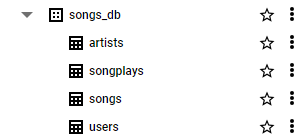